<a href="https://colab.research.google.com/github/acompalas/Deep-Learning-Review/blob/main/Linear_Regression/Ordinary_Least_Squares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression with Ordinary Least Squares

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces
from ipywidgets import interact, FloatSlider
from matplotlib import gridspec
from matplotlib import cm
# from IPython.display import display

%matplotlib inline

###Generate Random Datapoints

In [2]:
# Generate 1000 random x values between 0 and 10
x = np.random.uniform(0, 10, 1000)

# Ground truth parameters
true_slope = np.random.uniform(-2, 2)
true_intercept = np.random.uniform(0, 10)

# Gaussian noise
noise = np.random.normal(loc=0.0, scale=2.0, size=x.shape)
rss_true = np.sum(noise**2)

# Generate y values
y = true_slope * x + true_intercept + noise

print("Generated 1000 synthetic data points with Gaussian noise:")
print(f"- True slope (β₁):       {true_slope:.4f}")
print(f"- True intercept (β₀):   {true_intercept:.4f}")
print(f"- Noise standard dev σ:  2.0")
print(f"- Minimum achievable RSS (∑ε²): {rss_true:.2f}")

Generated 1000 synthetic data points with Gaussian noise:
- True slope (β₁):       0.1991
- True intercept (β₀):   4.2257
- Noise standard dev σ:  2.0
- Minimum achievable RSS (∑ε²): 3766.82


In [3]:
def plot_data(x, y, title="Data Plot", label="Data", color='red', y_hat=None, rss_true=None):
    plt.figure(figsize=(10, 6))

    # Plot scatter of true data
    plt.plot(x, y, 'o', ms=5, mec='k', color=color, alpha=0.6, label=label)

    if y_hat is not None:
        sort_idx = np.argsort(x)
        y_hat_sorted = y_hat.flatten()[sort_idx]
        rss = np.sum((y - y_hat.flatten())**2)
        rss_label = f"Fit (RSS = {rss:.2f})"
        if rss_true is not None:
            rss_label += f", True RSS = {rss_true:.2f}"
        plt.plot(x[sort_idx], y_hat_sorted, 'k-', lw=2, label=rss_label)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

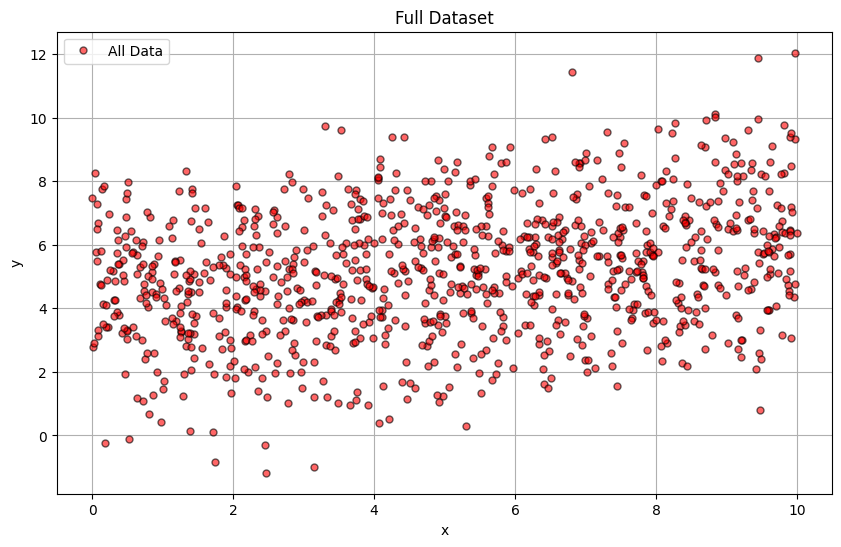

In [4]:
plot_data(x, y, title="Full Dataset", label="All Data", color='red')

## Interactive Optimization

### Residual Sum-of Squares

The goal of Linear Regression is to minimize the squared error between true datapoints and model predictions

$$RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2$$



In [5]:
# Constants
m = 2  # number of parameters
b0_opt = true_intercept
b1_opt = true_slope

# Dataset design matrix
X_full = np.column_stack((np.ones_like(x), x))
y_full = y.reshape(-1, 1)
y_mean = np.mean(y)

# 1D plotting grid
beta_range = np.linspace(-10, 15, 300)

# 2D meshgrid for surface plot
b0_vals = np.linspace(-5, 15, 100)
b1_vals = np.linspace(-3, 5, 100)
B0, B1 = np.meshgrid(b0_vals, b1_vals)

# Precompute full RSS surface
def compute_rss_surface(X, y, B0, B1):
    RSS = np.zeros_like(B0)
    for i in range(B0.shape[0]):
        for j in range(B0.shape[1]):
            beta = np.array([[B0[i, j]], [B1[i, j]]])
            y_hat = X @ beta
            RSS[i, j] = np.sum((y - y_hat) ** 2)
    return RSS

RSS_surface = compute_rss_surface(X_full, y_full, B0, B1)

### Plot linear fit

In [6]:
@interact(beta_0=FloatSlider(min=-10, max=10, step=0.1, value=y_mean),
          beta_1=FloatSlider(min=-5, max=5, step=0.1, value=0.0))
def plot_fit(beta_0, beta_1):
    beta = np.array([[beta_0], [beta_1]])
    y_hat = X_full @ beta
    rss = np.sum((y_full - y_hat) ** 2)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'o', ms=5, mec='k', color='red', alpha=0.6, label="Data")

    sort_idx = np.argsort(x)
    plt.plot(x[sort_idx], y_hat.flatten()[sort_idx], 'k-', lw=2, label=f"Fit (RSS = {rss:.2f}, True RSS = {rss_true:.2f}))")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Interactive Fit with Current β₀, β₁")
    plt.legend()
    plt.grid(True)
    plt.show()

interactive(children=(FloatSlider(value=5.196136028463697, description='beta_0', max=10.0, min=-10.0), FloatSl…

### 2-D Parabolas RSS Plot

In [7]:
@interact(beta_0=FloatSlider(min=-10, max=10, step=0.1, value=0.0),
          beta_1=FloatSlider(min=-5, max=5, step=0.1, value=0.0))
def plot_1d_rss(beta_0, beta_1):
    rss_beta0 = []
    rss_beta1 = []

    # Slice RSS across beta_0 (beta_1 fixed)
    for b0 in beta_range:
        beta = np.array([[b0], [beta_1]])
        y_hat = X_full @ beta
        rss = np.sum((y_full - y_hat) ** 2)
        rss_beta0.append(rss)

    # Slice RSS across beta_1 (beta_0 fixed)
    for b1 in beta_range:
        beta = np.array([[beta_0], [b1]])
        y_hat = X_full @ beta
        rss = np.sum((y_full - y_hat) ** 2)
        rss_beta1.append(rss)

    # Current RSS
    beta_current = np.array([[beta_0], [beta_1]])
    y_hat = X_full @ beta_current
    rss_current = np.sum((y_full - y_hat) ** 2)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(beta_range, rss_beta0)
    ax1.plot(beta_0, rss_current, 'ro', label=rf"$\beta_0$ = {beta_0:.2f}, RSS = {rss_current:.2f}, True RSS = {rss_true:.2f})")
    ax1.set_xlabel(r"$\beta_0$")
    ax1.set_ylabel("RSS")
    ax1.set_title(r"Loss as a Function of $\beta_0$")
    ax1.grid(True)
    ax1.legend()

    ax2.plot(beta_range, rss_beta1)
    ax2.plot(beta_1, rss_current, 'ro', label=rf"$\beta_1$ = {beta_1:.2f}, RSS = {rss_current:.2f}, True RSS = {rss_true:.2f})")
    ax2.set_xlabel(r"$\beta_1$")
    ax2.set_ylabel("RSS")
    ax2.set_title(r"Loss as a Function of $\beta_1$")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='beta_0', max=10.0, min=-10.0), FloatSlider(value=0.0…

### 3-D Surface and 2-D Contour Interactive RSS Plot

In [8]:
@interact(beta_0=FloatSlider(min=-5, max=15, step=0.1, value=0),
          beta_1=FloatSlider(min=-3, max=5, step=0.1, value=0))
def plot_2d_rss(beta_0, beta_1):
    beta = np.array([[beta_0], [beta_1]])
    y_hat = X_full @ beta
    rss = np.sum((y_full - y_hat) ** 2)

    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(B0, B1, RSS_surface, cmap=cm.viridis, alpha=0.9)
    ax1.scatter(beta_0, beta_1, rss, color='red', s=50, label="Current")
    ax1.set_xlabel(r"$\beta_0$")
    ax1.set_ylabel(r"$\beta_1$")
    ax1.set_zlabel("RSS")
    ax1.set_title("RSS Surface")
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    cp = ax2.contourf(B0, B1, RSS_surface, levels=50, cmap=cm.viridis)
    fig.colorbar(cp, ax=ax2)
    ax2.plot(beta_0, beta_1, 'ro', label=f"RSS: {rss:.2f}, True RSS = {rss_true:.2f})")
    ax2.set_xlabel(r"$\beta_0$")
    ax2.set_ylabel(r"$\beta_1$")
    ax2.set_title("RSS Contour")
    ax2.legend()

    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='beta_0', max=15.0, min=-5.0), FloatSlider(value=0.0,…

In [9]:
@interact(beta_0=FloatSlider(min=-10, max=10, step=0.1, value=y_mean),
          beta_1=FloatSlider(min=-5, max=5, step=0.1, value=0.0))
def combined_fit_and_rss(beta_0, beta_1):
    beta = np.array([[beta_0], [beta_1]])
    y_hat = X_full @ beta
    rss_current = np.sum((y_full - y_hat) ** 2)

    # Slice RSS over beta_0 and beta_1
    rss_beta0 = []
    rss_beta1 = []

    for b0 in beta_range:
        b = np.array([[b0], [beta_1]])
        rss_beta0.append(np.sum((y_full - (X_full @ b)) ** 2))

    for b1 in beta_range:
        b = np.array([[beta_0], [b1]])
        rss_beta1.append(np.sum((y_full - (X_full @ b)) ** 2))

    # Layout: 2 columns, right column has 2 rows
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1])

    # Left: scatter plot + fit
    ax0 = fig.add_subplot(gs[:, 0])  # spans both rows
    ax0.plot(x, y, 'o', ms=5, mec='k', color='red', alpha=0.6, label="Data")
    sort_idx = np.argsort(x)
    ax0.plot(x[sort_idx], y_hat.flatten()[sort_idx], 'k-', lw=2, label=f"Fit (RSS = {rss_current:.2f}), True RSS = {rss_true:.2f})")
    ax0.set_xlabel("x")
    ax0.set_ylabel("y")
    ax0.set_title("Interactive Fit with Current $\\beta_0$, $\\beta_1$")
    ax0.legend()
    ax0.grid(True)

    # Top-right: RSS vs beta_0
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.plot(beta_range, rss_beta0)
    ax1.plot(beta_0, rss_current, 'ro', label=rf"$\beta_0$ = {beta_0:.2f}")
    ax1.set_xlabel(r"$\beta_0$")
    ax1.set_ylabel("RSS")
    ax1.set_title("RSS vs $\\beta_0$")
    ax1.legend()
    ax1.grid(True)

    # Bottom-right: RSS vs beta_1
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.plot(beta_range, rss_beta1)
    ax2.plot(beta_1, rss_current, 'ro', label=rf"$\beta_1$ = {beta_1:.2f}")
    ax2.set_xlabel(r"$\beta_1$")
    ax2.set_ylabel("RSS")
    ax2.set_title("RSS vs $\\beta_1$")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=5.196136028463697, description='beta_0', max=10.0, min=-10.0), FloatSl…

In [10]:
@interact(beta_0=FloatSlider(min=-5, max=15, step=0.1, value=0),
          beta_1=FloatSlider(min=-3, max=5, step=0.1, value=0))
def plot_2d_rss_with_side(beta_0, beta_1):
    beta = np.array([[beta_0], [beta_1]])
    y_hat = X_full @ beta
    rss = np.sum((y_full - y_hat) ** 2)

    # Create figure and grid layout
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])

    # Left column, spans both rows: Fit to data
    ax0 = fig.add_subplot(gs[:, 0])
    ax0.plot(x, y, 'o', ms=5, mec='k', color='red', alpha=0.6, label="Data")
    sort_idx = np.argsort(x)
    ax0.plot(x[sort_idx], y_hat.flatten()[sort_idx], 'k-', lw=2, label=f"Fit (RSS = {rss:.2f})")
    ax0.set_xlabel("x")
    ax0.set_ylabel("y")
    ax0.set_title("Fit to Data with Current $\\beta_0$, $\\beta_1$")
    ax0.legend()
    ax0.grid(True)

    # Top-right: 3D RSS surface
    ax1 = fig.add_subplot(gs[0, 1], projection='3d')
    ax1.plot_surface(B0, B1, RSS_surface, cmap=cm.viridis, alpha=0.9)
    ax1.scatter(beta_0, beta_1, rss, color='red', s=50, label="Current")
    ax1.set_xlabel(r"$\beta_0$")
    ax1.set_ylabel(r"$\beta_1$")
    ax1.set_zlabel("RSS")
    ax1.set_title("RSS Surface")
    ax1.legend()

    # Bottom-right: Contour plot
    ax2 = fig.add_subplot(gs[1, 1])
    cp = ax2.contourf(B0, B1, RSS_surface, levels=50, cmap=cm.viridis)
    fig.colorbar(cp, ax=ax2)
    ax2.plot(beta_0, beta_1, 'ro', label=f"RSS: {rss:.2f}")
    ax2.set_xlabel(r"$\beta_0$")
    ax2.set_ylabel(r"$\beta_1$")
    ax2.set_title("RSS Contour")
    ax2.legend()

    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='beta_0', max=15.0, min=-5.0), FloatSlider(value=0.0,…

###Train-Test Split (80-20) with Numpy

In [11]:
# Stack x and y together to keep correspondence when shuffling
data = np.stack((x, y), axis=1)

# Shuffle the data
np.random.shuffle(data)

# Split back into x and y
x_shuffled, y_shuffled = data[:, 0], data[:, 1]

# 80/20 split index
split_idx = int(0.8 * len(x))

# Split the data
x_train, y_train = x_shuffled[:split_idx], y_shuffled[:split_idx]
x_test, y_test = x_shuffled[split_idx:], y_shuffled[split_idx:]

print(f"Train size: {len(x_train)}, Test size: {len(x_test)}")

Train size: 800, Test size: 200


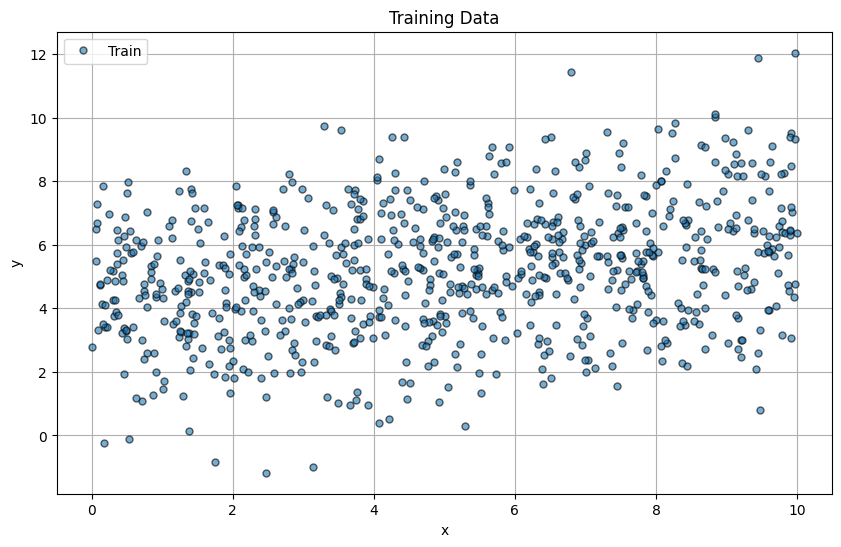

In [12]:
# Plot training data
plot_data(x_train, y_train, title="Training Data", label="Train", color='C0')

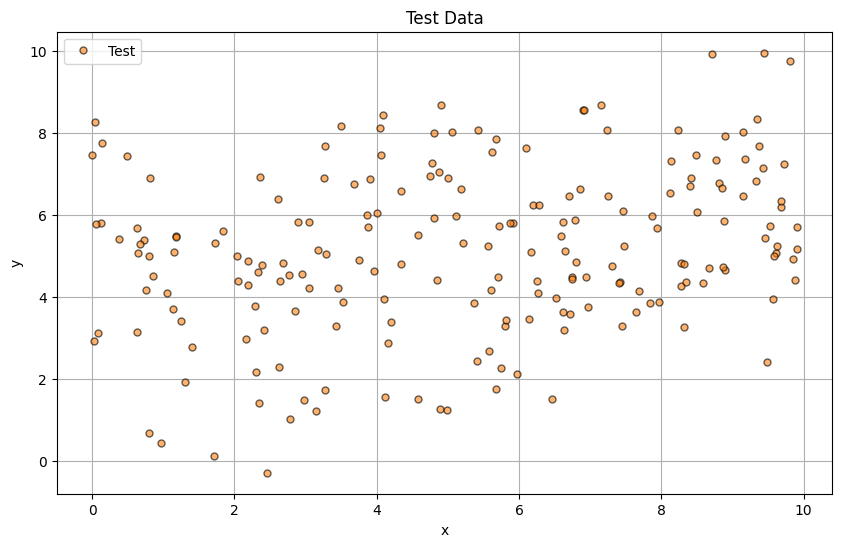

In [13]:
# Plot test data
plot_data(x_test, y_test, title="Test Data", label="Test", color='C1')

### Ordinary Least Squares

$$\hat{y} = \beta_0 + \beta_1 x = X \boldsymbol{\beta}$$

Where:
$$
X =
\begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_n
\end{bmatrix}
\in \mathbb{R}^{n \times 2},
\quad
\boldsymbol{\beta} =
\begin{bmatrix}
\beta_0 \\
\beta_1
\end{bmatrix}
\in \mathbb{R}^{2 \times 1}
$$

We want to find the best-fit parameters that minimize the residual sum of squares (RSS):

$$
\text{RSS} = \| \mathbf{y} - X\boldsymbol{\beta} \|^2 = (\mathbf{y} - X\boldsymbol{\beta})^T(\mathbf{y} - X\boldsymbol{\beta})
$$

To minimize RSS, we take the derivative with respect to $\boldsymbol{\beta}$ and set it to zero:

$$
\frac{\partial}{\partial \boldsymbol{\beta}} \left( \mathbf{y} - X\boldsymbol{\beta} \right)^T \left( \mathbf{y} - X\boldsymbol{\beta} \right) = 0
$$

Expanding and solving:

$$
-2 X^T (\mathbf{y} - X \boldsymbol{\beta}) = 0 \\
\Rightarrow X^T X \boldsymbol{\beta} = X^T \mathbf{y}
$$

So the optimal parameters are given by:

$$
\boldsymbol{\beta} = (X^T X)^{-1} X^T \mathbf{y}
$$

In [14]:
# Construct the design matrix X_train with bias term (column of 1s)
X_train = np.column_stack((np.ones_like(x_train), x_train))  # shape: (n_train, 2)
y_train_vec = y_train.reshape(-1, 1)  # shape: (n_train, 1)

# Closed-form OLS: beta = (X^T X)^(-1) X^T y
beta_hat = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train_vec

# Extract coefficients
b_hat, w_hat = beta_hat[0, 0], beta_hat[1, 0]

print("Coeffient vector:\n", beta_hat)
print("\nEstimated intercept (beta_0):", b_hat)
print("True intercept: ", true_intercept)
print("\nEstimated slope (beta_1):", w_hat)
print("True Slope: ", true_slope)

Coeffient vector:
 [[4.21164398]
 [0.19931768]]

Estimated intercept (beta_0): 4.211643983230482
True intercept:  4.225665755737618

Estimated slope (beta_1): 0.19931768112048387
True Slope:  0.19911367527737855


###Plot on Train and Test

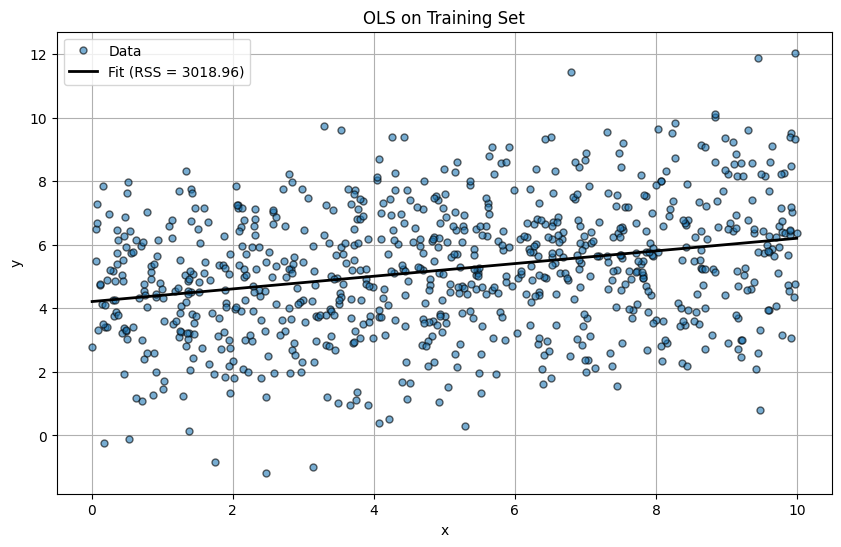

In [15]:
# Predict on train
y_train_pred = X_train @ beta_hat

# Plot training data with fit
plot_data(x_train, y_train, title="OLS on Training Set", color='C0', y_hat=y_train_pred)

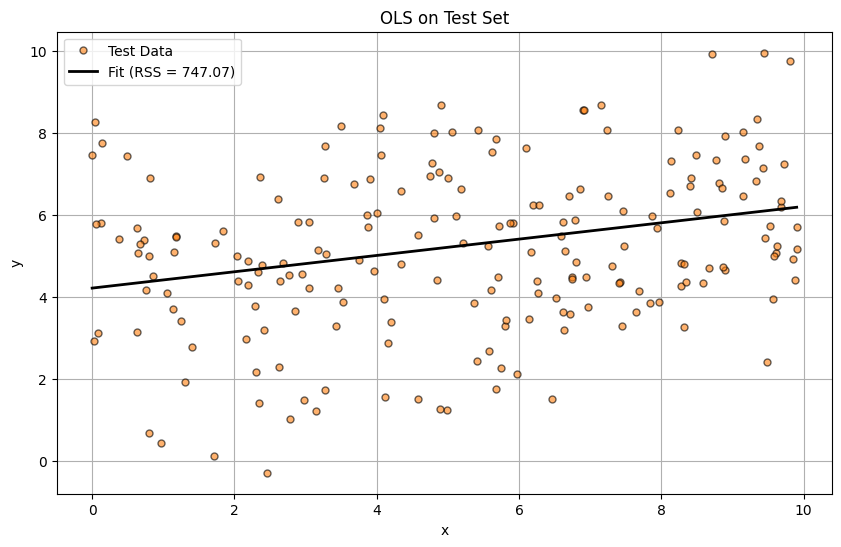

In [16]:
# Construct test design matrix
X_test = np.column_stack((np.ones_like(x_test), x_test))  # shape: (n_test, 2)

# Predict using beta_hat
y_test_pred = X_test @ beta_hat  # shape: (n_test, 1)

# Plot training data with fit
plot_data(x_test, y_test, title="OLS on Test Set", label="Test Data", color='C1', y_hat=y_test_pred)

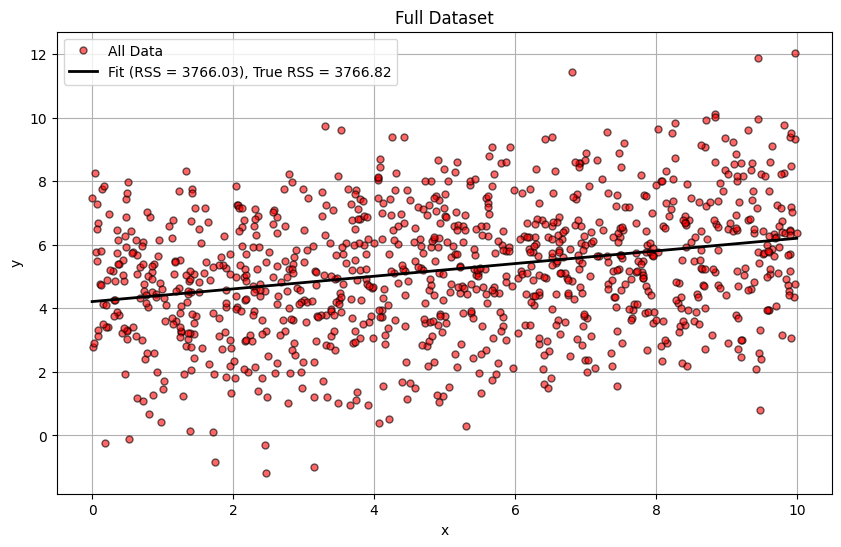

In [17]:
# Construct test design matrix
X_full = np.column_stack((np.ones_like(x), x))  # shape: (n_test, 2)

# Predict using beta_hat
y_hat = X_full @ beta_hat  # shape: (n_test, 1)

plot_data(x, y, title="Full Dataset", label="All Data", color='red', y_hat=y_hat, rss_true=rss_true)

### $R^2$-test

The $R^2$ score measures the proportion of variance in the dependent variable that is predictable from the independent variable(s)

Let $y$ be the true values and $\hat{y}$ be the predicted values. Then:

$$
R^2 = 1 - \frac{RSS}{TSS}
$$

$$RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

$$TSS = \sum_{i=1}^n (y_i - \bar{y})^2$$

Where:

- $RSS$ is the **residual sum of squares** centered around $\hat{y}$
- $TSS$ is the **total sum of squares** centered around the mean
- $R^2 = 1$: perfect fit  
- $R^2 = 0$: model does no better than predicting the mean  
- $R^2 < 0$: model performs worse than a constant mean predictor

In [18]:
def r2_score(y_true, y_pred):
    rss = np.sum((y_true - y_pred.flatten())**2)
    tss = np.sum((y_true - np.mean(y_true))**2)
    return 1 - rss / tss, rss

In [19]:
# Compute R² for train and test
r2_train, irss = r2_score(y_train, y_train_pred)
r2_test, orss = r2_score(y_test, y_test_pred)

print(f"Total Sum-of Squares: {np.sum((y - np.mean(y))**2):.4f}")
print(f"\nTotal RSS: {rss_true:.4f}")
print(f"Train + Test RSS: {irss+orss:.4f}")

print(f"\nIn-Sample RSS: {irss:.4f}")
print(f"Out-of-Sample RSS: {orss:.4f}")

print(f"\nR² on Training Set: {r2_train:.4f}")
print(f"R² on Test Set:     {r2_test:.4f}")

Total Sum-of Squares: 4078.9731

Total RSS: 3766.8248
Train + Test RSS: 3766.0311

In-Sample RSS: 3018.9600
Out-of-Sample RSS: 747.0711

R² on Training Set: 0.0780
R² on Test Set:     0.0702


### Reduced $\chi^2$ Test

The reduced chi-squared statistic helps evaluate the **goodness of fit** under the assumption of Gaussian errors.


#### Definition:

$$
\chi^2 = \sum_{i=1}^n \frac{(O_i - E_i)^2}{\sigma_i^2} \approx \frac{RSS}{\sigma^2}
$$

Where:
- $O_i$ are the observed values (true $y$ values)
- $E_i$ are the expected values (model predictions $\hat{y}$)
- $\sigma_i$ is the standard deviation of the noise (assumed constant or known)


#### Reduced Chi-Squared:

$$
\chi^2_\nu = \frac{\chi^2}{\nu} = \frac{RSS}{\sigma^2\nu}
\quad \text{where} \quad
\nu = n - m
$$

- $n$: number of observations  
- $m$: number of fitted parameters (e.g., slope + intercept = 2)  
- $\nu$: degrees of freedom

#### Interpretation:

- $\chi^2_\nu \approx 1$ ⇒ model fits data within expected noise  
- $\chi^2_\nu > 1$ ⇒ model underfits or residuals larger than expected  
- $\chi^2_\nu < 1$ ⇒ model may be overfitting or noise overestimated

In [20]:
def reduced_chi_squared(y_true, y_pred, sigma, num_params):
    rss = np.sum((y_true - y_pred.flatten()) ** 2)
    dof = len(y_true) - num_params  # ν = n - m
    chi2_red = rss / (dof * sigma**2)
    return chi2_red

In [21]:
# Assume known noise sigma from data generation step
sigma = 2.0
m = 2  # intercept + slope

chi2_train = reduced_chi_squared(y_train, y_train_pred, sigma, m)
chi2_test = reduced_chi_squared(y_test, y_test_pred, sigma, m)

print(f"Reduced χ² on Training Set: {chi2_train:.4f}")
print(f"Reduced χ² on Test Set:     {chi2_test:.4f}")

Reduced χ² on Training Set: 0.9458
Reduced χ² on Test Set:     0.9433


### Clean Metadata

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import nbformat

# Load your notebook
notebook_path  = '/content/drive/MyDrive/Deep-Learning-Review/Linear Regression/Ordinary_Least_Squares.ipynb'  # change if needed

with open(notebook_path, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

# Ensure 'state' key exists in 'metadata.widgets'
widgets_meta = nb['metadata'].get('widgets', {})
if 'state' not in widgets_meta:
    widgets_meta['state'] = {}
    nb['metadata']['widgets'] = widgets_meta
    print("Added empty 'state' key to metadata.widgets")

# Save the notebook back
with open(notebook_path, 'w', encoding='utf-8') as f:
    nbformat.write(nb, f)